In [1]:
import numpy as np
import pandas as pd

file_path = "./data/multi_asset_etf_data.xlsx"

excess_returns_df = pd.read_excel(file_path, sheet_name="excess returns", parse_dates=["Date"], index_col="Date")
excess_returns_df = excess_returns_df.drop(columns=["QAI"])
excess_returns_df = excess_returns_df.sort_index()

excess_returns_df


,BWX,DBC,EEM,EFA,HYG,IEF,IYR,PSP,SPY,TIP
Date,,,,,,,,,,
2011-02-28,0.007027,0.042120,-0.000027,0.035908,0.014763,-0.001674,0.045614,0.040556,0.035147,0.007618
2011-03-31,0.008755,0.026909,0.063224,-0.023555,0.000752,-0.001218,-0.010607,0.016995,0.000448,0.012231
2011-04-30,0.048760,0.045514,0.027283,0.056214,0.015932,0.018369,0.046589,0.058627,0.028917,0.023735
2011-05-31,-0.012945,-0.051124,-0.028800,-0.021461,0.001933,0.025654,0.010733,-0.040965,-0.010615,0.003259
2011-06-30,0.000230,-0.042318,-0.009027,-0.011781,-0.005378,-0.004716,-0.030733,-0.042254,-0.016542,0.007876
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,-0.002198,0.024463,0.018388,0.044877,0.010472,0.003033,0.015780,0.064862,0.023724,0.010570
2025-02-28,0.011376,-0.001250,0.008855,0.026915,0.007087,0.025382,0.035246,-0.042722,-0.015310,0.018957
2025-03-31,0.007510,0.019885,0.008497,-0.001004,-0.013701,0.000577,-0.026225,-0.063669,-0.058562,0.003954


One-step Out-of-Sample (OOS) Performance

In [2]:
def in_sample_perf(train_matrix: np.ndarray, weights: np.ndarray):
    """
    Compute in-sample mean, vol, and Sharpe for a given weight vector.
    train_matrix: T x N matrix of in-sample excess returns
    weights: N x 1 weight vector
    """
    # portfolio returns over time
    r_in = train_matrix @ weights

    # mean, vol, sharpe (per month)
    mu_in = r_in.mean()
    vol_in = r_in.std(ddof=1)
    sharpe_in = mu_in / vol_in if vol_in > 0 else np.nan

    return mu_in, vol_in, sharpe_in


In [3]:
train = excess_returns_df.loc[: "2023-12-31"]
train_matrix = train.values
n = train.shape[1]

#Equally-Weighted
w_ew = np.ones(n) / n
print("Weights (Equally weighted):")
print(w_ew, "\n")

#Risk-Parity
asset_vars = train.var(ddof = 1).values
w_rp_unnormalized = 1 / asset_vars
w_rp = w_rp_unnormalized / np.sum(w_rp_unnormalized)
print("Weights (Risk Parity):")
print(w_rp, "\n")

#Mean-Variance
cov_matrix = train.cov().values
mean_vector = train.mean()
cov_inv = np.linalg.inv(cov_matrix)

w_mv_unnormalized = cov_inv @ mean_vector.values
w_mv = w_mv_unnormalized / np.sum(w_mv_unnormalized)
print("Weights (Mean-Variance):")
print(w_mv)

Weights (Equally weighted):
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1] 

Weights (Risk Parity):
[0.13248043 0.02951737 0.026172   0.03649623 0.14042055 0.21930187
 0.03037919 0.01821558 0.04146344 0.32555333] 

Weights (Mean-Variance):
[-9.12923733e-01  3.92314151e-03  4.63293181e-02 -1.24288085e-01
  2.24423404e-01  1.12367887e+00 -2.36861588e-01 -2.49964018e-01
  1.12639908e+00 -7.16390665e-04]


In [4]:
# Portfolio in-sample returns using tangency weights (unscaled)
mu_ew, vol_ew, sharpe_ew = in_sample_perf(train_matrix, w_ew)
mu_rp, vol_rp, sharpe_rp = in_sample_perf(train_matrix, w_rp)
mu_mv, vol_mv, sharpe_mv = in_sample_perf(train_matrix, w_mv) 

L_ew = mu_mv / mu_ew
L_rp = mu_mv / mu_rp

w_ew_scaled = L_ew * w_ew
w_rp_scaled = L_rp * w_rp
w_mv_scaled = w_mv

In [5]:
test = excess_returns_df.loc["2024-01-01":]
test_matrix = test.values

#Applying scaled weights to out-of-sample
mu_ew_s, vol_ew_s, sharpe_ew_s = in_sample_perf(test_matrix, w_ew_scaled)
mu_rp_s, vol_rp_s, sharpe_rp_s = in_sample_perf(test_matrix, w_rp_scaled)
mu_mv_s, vol_mv_s, sharpe_mv_s = in_sample_perf(test_matrix, w_mv_scaled)

print("\nOut-of-sample annualized (scaled to μ_port):")
print(f"EW  - mean={mu_ew_s * 12:.4f}, vol={vol_ew_s * np.sqrt(12):.4f}, Sharpe={sharpe_ew_s * np.sqrt(12):.3f}, L={L_ew:.2f}")
print(f"RP  - mean={mu_rp_s * 12:.4f}, vol={vol_rp_s * np.sqrt(12):.4f}, Sharpe={sharpe_rp_s * np.sqrt(12):.3f}, L={L_rp:.2f}")
print(f"MV  - mean={mu_mv_s * 12:.4f}, vol={vol_mv_s * np.sqrt(12):.4f}, Sharpe={sharpe_mv_s * np.sqrt(12):.3f}, L=1.00")



Out-of-sample annualized (scaled to μ_port):
EW  - mean=0.0992, vol=0.1905, Sharpe=0.521, L=2.87
RP  - mean=0.0358, vol=0.2424, Sharpe=0.147, L=4.54
MV  - mean=0.1216, vol=0.1200, Sharpe=1.014, L=1.00


Rolling OOS Performance

In [6]:
mus_ew, vols_ew = [], []
mus_rp, vols_rp = [], []
mus_mv, vols_mv = [], []
mus_reg, vols_reg = [], []

for y in range(2015, 2025):
    #train on year
    train = excess_returns_df.loc[: f"{y}-12-31"]
    #test on next year
    test  = excess_returns_df.loc[f"{y+1}-01-01" : f"{y+1}-12-31"]
    train_matrix = train.values
    test_matrix = test.values
    n = train.shape[1]

    #Compute in-sample weights for different strategies

    #Equally-Weighted
    w_ew = np.ones(n) / n

    #Risk-Parity
    asset_vars = train.var(ddof = 1).values
    w_rp_unnormalized = 1 / asset_vars
    w_rp = w_rp_unnormalized / np.sum(w_rp_unnormalized)

    #Mean-Variance
    cov_matrix = train.cov().values
    mean_vector = train.mean()
    cov_inv = np.linalg.inv(cov_matrix)

    w_mv_unnormalized = cov_inv @ mean_vector.values
    w_mv = w_mv_unnormalized / np.sum(w_mv_unnormalized)

    # Regularized MV (REG): Σ_reg = (Σ + Σ_D)/2
    Sigma_D = np.diag(np.diag(cov_matrix))
    Sigma_reg = 0.5 * (cov_matrix + Sigma_D)
    w_reg_dir = np.linalg.inv(Sigma_reg) @ train.mean().values
    w_reg = w_reg_dir / w_reg_dir.sum()

    #Compute the average mean return of the portfolio for these weights over the training period

    mu_ew_insample = (train_matrix @ w_ew).mean()
    mu_rp_insample = (train_matrix @ w_rp).mean()
    mu_mv_insample = (train_matrix @ w_mv).mean()
    mu_reg_insample = (train_matrix @ w_reg).mean()

        #Scale to same mean
    L_ew = mu_mv_insample / mu_ew_insample if abs(mu_ew_insample) > 1e-12 else 0
    L_rp  = mu_mv_insample / mu_rp_insample  if abs(mu_rp_insample)  > 1e-12 else 0
    L_reg = mu_mv_insample / mu_reg_insample if abs(mu_reg_insample) > 1e-12 else 0

    w_ew_scaled  = L_ew  * w_ew
    w_rp_scaled  = L_rp  * w_rp
    w_mv_scaled  = w_mv              # baseline (L = 1)
    w_reg_scaled = L_reg * w_reg

    # OOS stats for the next period
    mu_ew_s,  vol_ew_s,  sharpe_ew_s  = in_sample_perf(test_matrix, w_ew_scaled)
    mu_rp_s,  vol_rp_s,  sharpe_rp_s  = in_sample_perf(test_matrix, w_rp_scaled)
    mu_mv_s,  vol_mv_s,  sharpe_mv_s  = in_sample_perf(test_matrix, w_mv_scaled)
    mu_reg_s, vol_reg_s, sharpe_reg_s = in_sample_perf(test_matrix, w_reg_scaled)

    mus_ew.append(mu_ew_s)
    vols_ew.append(vol_ew_s)

    mus_rp.append(mu_rp_s)
    vols_rp.append(vol_rp_s)

    mus_mv.append(mu_mv_s)
    vols_mv.append(vol_mv_s)

    mus_reg.append(mu_reg_s)
    vols_reg.append(vol_reg_s)

In [7]:
# EW
mu_ew_rolling  = np.mean(mus_ew)
vol_ew_rolling = np.sqrt(np.sum([v**2 for v in vols_ew]))
sharpe_ew_rolling = mu_ew_rolling/vol_ew_rolling

# RP
mu_rp_rolling  = np.mean(mus_rp)
vol_rp_rolling = np.sqrt(np.sum([v**2 for v in vols_rp]))
sharpe_rp_rolling = mu_rp_rolling/vol_rp_rolling

# MV
mu_mv_rolling  = np.mean(mus_mv)
vol_mv_rolling = np.sqrt(np.sum([v**2 for v in vols_mv]))
sharpe_mv_rolling = mu_mv_rolling/vol_mv_rolling

# REG
mu_reg_rolling  = np.mean(mus_reg)
vol_reg_rolling = np.sqrt(np.sum([v**2 for v in vols_reg]))
sharpe_reg_rolling = mu_reg_rolling/vol_reg_rolling


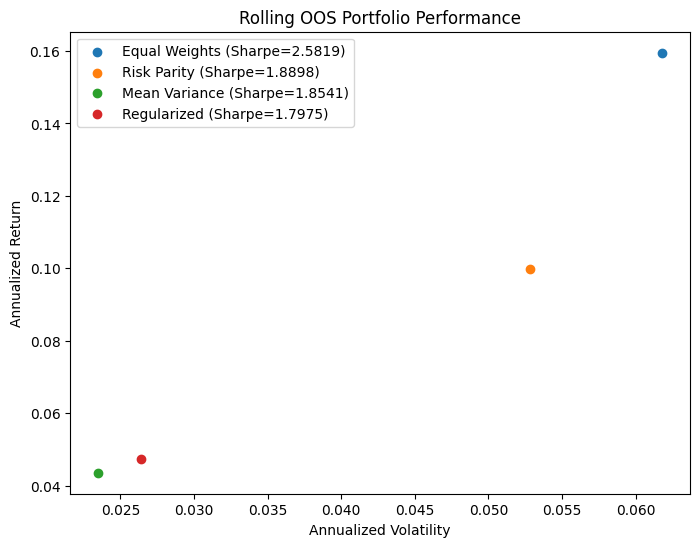

,Strategy,Annualized Mean,Annualized Vol,Annualized Sharpe
0,Equal Weights,0.159513,0.061782,2.581855
1,Risk Parity,0.099870,0.052848,1.889758
2,Mean Variance,0.043584,0.023507,1.854108
3,Regularized,0.047403,0.026372,1.797467


In [9]:
import matplotlib.pyplot as plt
strategies = ["Equal Weights", "Risk Parity", "Mean Variance", "Regularized"]

#Means
y_vals = np.array([mu_ew_rolling, mu_rp_rolling, mu_mv_rolling, mu_reg_rolling]) * 12

#Variances
x_vals = np.array([vol_ew_rolling, vol_rp_rolling, vol_mv_rolling, vol_reg_rolling]) / np.sqrt(12)

sharpes = y_vals/x_vals

# Plot mean-variance
plt.figure(figsize=(8,6))
for x, y, s, label in zip(x_vals, y_vals, sharpes, strategies):
    plt.scatter(x, y, label=f"{label} (Sharpe={s:.4f})")

plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.title("Rolling OOS Portfolio Performance")
plt.legend()
plt.show()

summary_stats = pd.DataFrame({'Strategy': strategies, 'Annualized Mean' : y_vals, 'Annualized Vol' : x_vals, 'Annualized Sharpe': sharpes})
display(summary_stats)